# Urban Mobility: An Analysis of NYC Uber Trip Data

--------------------
## **Context**
--------------------

The landscape of urban transportation has been revolutionized by ridesharing services like Uber. This new paradigm generates vast amounts of data that hold the key to understanding mobility patterns within a city. By analyzing this data, we can uncover trends in demand, identify geographic hotspots, and understand how people move through the urban environment at different times.

The key to success in this volatile market is to effectively match supply (drivers) with demand (riders). This project aims to analyze a large dataset of Uber trips in New York City to extract insights that can help optimize operations and improve service efficiency.

------------------
## **Objective**
------------------

To perform a comprehensive analysis of Uber trip data to identify key patterns in demand related to time and location. The ultimate goal is to translate these findings into actionable recommendations for business strategy, such as driver allocation and dynamic pricing.

-----------------------------
## **Key Questions**
-----------------------------

1. What are the overarching daily, weekly, and monthly trends in ride demand?
2. Which hours of the day and days of the week experience the highest demand (peak hours)?
3. What are the geographical hotspots for pickups and drop-offs across NYC?
4. Can we build a predictive model to forecast future ride demand to help with resource planning?

-----------------------------
## **Dataset Description**
-----------------------------

The data contains details about taxi trips including timestamps, locations, passenger counts, and trip durations.

*  pickup_datetime: Date and time when the trip started
*  dropoff_datetime: Date and time when the trip ended
*  pickup_longitude: Longitude coordinate of the pickup location
*  pickup_latitude: Latitude coordinate of the pickup location
*  dropoff_longitude: Longitude coordinate of the dropoff location
*  dropoff_latitude: Latitude coordinate of the dropoff location
*  passenger_count: Number of passengers in the trip
*  trip_duration: Duration of the trip (in seconds)

## 1. Project Setup and Data Ingestion

We begin by setting up the environment, installing necessary libraries, and defining paths for our data and models. The first step in our pipeline is to ingest the raw Uber trip data from a CSV file into a structured SQLite database. This approach is robust and scalable, allowing us to efficiently handle a large dataset by processing it in chunks.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Install the required libraries that are not pre-installed in Colab.
!pip install prophet folium tabulate

import os
import logging
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from sqlalchemy import create_engine, text
from prophet import Prophet
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import datetime
import plotly.express as px
import matplotlib.pyplot as plt

# Reset existing handlers
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Standard paths pointing to your Google Drive
DRIVE_DIR = '/content/drive/My Drive/Colab Notebooks/Urban_Mobility_Data_Analysis'
DATA_DIR = os.path.join(DRIVE_DIR, 'data')
MODELS_DIR = os.path.join(DRIVE_DIR, 'models')
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
CSV_PATH = os.path.join(DATA_DIR, 'uber_data.csv')
DB_PATH = os.path.join(DATA_DIR, 'uber.db')
TABLE_NAME = 'uber_trips'
CLEANED_CSV_PATH = os.path.join(DATA_DIR, 'cleaned.csv')
HOURLY_DEMAND_PATH = os.path.join(DATA_DIR, 'demand_by_hour.csv')
MODEL_PATH = os.path.join(MODELS_DIR, 'prophet_model.pkl')

### 1a. Ingest Raw Data to Database

In [3]:
def ingest_data(csv_path, db_path, table_name):
    """
    Reads taxi trip data from a CSV file, converts datetime columns,
    and ingests it into a SQLite database table.
    """
    if not os.path.exists(os.path.dirname(db_path)):
        os.makedirs(os.path.dirname(db_path))

    logging.info(f"Connecting to database at {db_path}...")
    engine = create_engine(f'sqlite:///{db_path}')

    expected_columns = [
        'pickup_datetime', 'dropoff_datetime', 'pickup_longitude',
        'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
        'passenger_count', 'trip_duration'
    ]

    chunksize = 100000
    chunk_num = 0

    logging.info(f"Reading and ingesting data from {csv_path} in chunks...")
    for chunk in pd.read_csv(csv_path, chunksize=chunksize):
        try:
            # Keep only the desired columns
            chunk = chunk[expected_columns]

            chunk['pickup_datetime'] = pd.to_datetime(chunk['pickup_datetime'])
            chunk['dropoff_datetime'] = pd.to_datetime(chunk['dropoff_datetime'])

            if chunk_num == 0:
                chunk.to_sql(table_name, engine, index=False, if_exists='replace')
            else:
                chunk.to_sql(table_name, engine, index=False, if_exists='append')

            chunk_num += 1
            logging.info(f"Ingested chunk {chunk_num}...")
        except KeyError as e:
            logging.error(f"Column error in chunk {chunk_num+1}: {e}. Skipping this chunk.")
            continue

    logging.info("Data ingestion complete.")

if __name__ == '__main__':
    if os.path.exists(CSV_PATH):
        ingest_data(CSV_PATH, DB_PATH, TABLE_NAME)
    else:
        logging.error(f"Error: Dataset not found at {CSV_PATH}. Please download the dataset first.")

2025-09-28 17:58:57,605 - INFO - Connecting to database at /content/drive/My Drive/Colab Notebooks/Urban_Mobility_Data_Analysis/data/uber.db...
2025-09-28 17:58:57,705 - INFO - Reading and ingesting data from /content/drive/My Drive/Colab Notebooks/Urban_Mobility_Data_Analysis/data/uber_data.csv in chunks...
2025-09-28 17:59:28,124 - INFO - Ingested chunk 1...
2025-09-28 17:59:31,347 - INFO - Ingested chunk 2...
2025-09-28 17:59:34,004 - INFO - Ingested chunk 3...
2025-09-28 17:59:36,676 - INFO - Ingested chunk 4...
2025-09-28 17:59:39,356 - INFO - Ingested chunk 5...
2025-09-28 17:59:43,371 - INFO - Ingested chunk 6...
2025-09-28 17:59:46,174 - INFO - Ingested chunk 7...
2025-09-28 17:59:48,882 - INFO - Ingested chunk 8...
2025-09-28 17:59:51,576 - INFO - Ingested chunk 9...
2025-09-28 17:59:54,309 - INFO - Ingested chunk 10...
2025-09-28 17:59:58,233 - INFO - Ingested chunk 11...
2025-09-28 18:00:01,078 - INFO - Ingested chunk 12...
2025-09-28 18:00:03,989 - INFO - Ingested chunk 13.

## 2. Data Cleaning and Preprocessing
A crucial step in any data analysis project is cleaning the data. Raw data often contains errors, outliers, and inconsistencies. Here, we perform several cleaning operations:
*   **Removing Null Values:** Ensure data integrity.
*   **Filtering Invalid Entries:** Remove trips with zero passengers.
*   **Geographic Filtering:** Keep only the trips that start and end within the geographical boundaries of New York City to remove outliers.
*   **Trip Duration Filtering:** Filter out trips that are too short (less than 1 minute) or excessively long (over 2.5 hours) to remove potential data entry errors.

In [4]:
def clean_data(db_path, table_name, output_path):
    """
    Connects to the SQLite database, cleans the trip data, and saves it.
    """
    logging.info(f"Connecting to database: {db_path}")
    engine = create_engine(f'sqlite:///{db_path}')

    query = text(f"SELECT * FROM {table_name}")
    with engine.connect() as conn:
        df = pd.read_sql(query, conn, parse_dates=['pickup_datetime', 'dropoff_datetime'])

    logging.info(f"Initial data size: {len(df)}")
    logging.info("Cleaning data...")

    df.dropna(inplace=True)
    df = df[(df['passenger_count'] > 0)]

    # Geographic Bounding Box Filter
    NYC_BOUNDS = {
        'min_lon': -74.3, 'max_lon': -73.7,
        'min_lat': 40.5, 'max_lat': 41.0,
    }

    logging.info("Applying geographical bounding box filter...")
    df = df[
        (df['pickup_latitude'].between(NYC_BOUNDS['min_lat'], NYC_BOUNDS['max_lat'])) &
        (df['pickup_longitude'].between(NYC_BOUNDS['min_lon'], NYC_BOUNDS['max_lon'])) &
        (df['dropoff_latitude'].between(NYC_BOUNDS['min_lat'], NYC_BOUNDS['max_lat'])) &
        (df['dropoff_longitude'].between(NYC_BOUNDS['min_lon'], NYC_BOUNDS['max_lon']))
    ]
    logging.info(f"Data size after geo-filter: {len(df)}")

    # Filter trip_duration, which is in seconds (1 min to 1:30 hours)
    logging.info("Applying trip duration filter (1-90 minutes)...")
    df = df[(df['trip_duration'] > 60) & (df['trip_duration'] < 5400)]

    # 'trip_duration_minutes' column for easier interpretation
    df['trip_duration_minutes'] = round(df['trip_duration'] / 60.0 , 2)

    # first five observations
    logging.info("First five obervations for NYC rides" + "\n" + tabulate(df.head(), headers='keys', tablefmt='fancy_grid'))

    # last five observations
    logging.info("Last five obervations for NYC rides" + "\n" + tabulate(df.tail(), headers='keys', tablefmt='fancy_grid'))


    logging.info(f"Final cleaned data size: {len(df)}")

    logging.info(f"Saving cleaned data to {output_path}...")
    df.to_csv(output_path, index=False)
    logging.info("Data cleaning complete.")

if __name__ == '__main__':
    if os.path.exists(DB_PATH):
        clean_data(DB_PATH, TABLE_NAME, CLEANED_CSV_PATH)
    else:
        logging.error(f"Database not found at {DB_PATH}. Please run data_ingest.py first.")

2025-09-28 18:00:08,694 - INFO - Connecting to database: /content/drive/My Drive/Colab Notebooks/Urban_Mobility_Data_Analysis/data/uber.db
2025-09-28 18:00:41,829 - INFO - Initial data size: 1458644
2025-09-28 18:00:41,830 - INFO - Cleaning data...
2025-09-28 18:00:41,951 - INFO - Applying geographical bounding box filter...
2025-09-28 18:00:42,021 - INFO - Data size after geo-filter: 1457586
2025-09-28 18:00:42,022 - INFO - Applying trip duration filter (1-90 minutes)...
2025-09-28 18:00:42,112 - INFO - First five obervations for NYC rides
╒════╤═════════════════════╤═════════════════════╤════════════════════╤═══════════════════╤═════════════════════╤════════════════════╤═══════════════════╤═════════════════╤═════════════════════════╕
│    │ pickup_datetime     │ dropoff_datetime    │   pickup_longitude │   pickup_latitude │   dropoff_longitude │   dropoff_latitude │   passenger_count │   trip_duration │   trip_duration_minutes │
╞════╪═════════════════════╪═════════════════════╪═════

## 3. Feature Engineering: Creating an Hourly Demand Time Series
To analyze and forecast demand, we need to transform our trip-level data into a time series. We aggregate the number of trips for each hour, creating a dataset that shows total ride demand over time. This hourly aggregation is essential for both our exploratory analysis and for training our Prophet forecasting model.

In [5]:
def create_hourly_demand(cleaned_data_path, output_path):
    """
    Reads the cleaned trip data and aggregates it to create a time-series
    of hourly ride demand, formatted for Prophet.
    """
    logging.info(f"Reading cleaned data from {cleaned_data_path}...")
    df = pd.read_csv(cleaned_data_path, parse_dates=['pickup_datetime'])

    df.set_index('pickup_datetime', inplace=True)

    logging.info("Aggregating data by the hour...")
    demand_by_hour = df.resample('h').size().asfreq('h', fill_value=0).reset_index(name='demand')
    demand_by_hour.rename(columns={'pickup_datetime': 'ds', 'demand': 'y'}, inplace=True)

    logging.info(f"Saving hourly demand data to {output_path}...")
    demand_by_hour.to_csv(output_path, index=False)
    logging.info("Hourly demand dataset created successfully.")

if __name__ == '__main__':
    if os.path.exists(CLEANED_CSV_PATH):
        create_hourly_demand(CLEANED_CSV_PATH, HOURLY_DEMAND_PATH)
    else:
        logging.error(f"Cleaned data not found at {CLEANED_CSV_PATH}. Please run data_clean.py first.")

2025-09-28 18:01:04,986 - INFO - Reading cleaned data from /content/drive/My Drive/Colab Notebooks/Urban_Mobility_Data_Analysis/data/cleaned.csv...
2025-09-28 18:01:10,533 - INFO - Aggregating data by the hour...
2025-09-28 18:01:12,666 - INFO - Saving hourly demand data to /content/drive/My Drive/Colab Notebooks/Urban_Mobility_Data_Analysis/data/demand_by_hour.csv...
2025-09-28 18:01:14,296 - INFO - Hourly demand dataset created successfully.


## 4. Demand Forecasting with Prophet
To move from analysis to prediction, we will train a time series forecasting model. We use Facebook's **Prophet**, which is well-suited for this type of data as it can effectively model multiple seasonalities (daily, weekly).

We first evaluate the model's performance on a test set and then train a final model on all available data.

In [6]:
# A safe function to calculate MAPE to avoid division by zero
def calculate_mape(y_true, y_pred):
    """Calculates Mean Absolute Percentage Error, handling zero values."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    if np.sum(non_zero_mask) == 0:
        return 0.0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

def train_and_save_model(data_path, model_output_path):
    """
    Trains a Prophet forecasting model on the hourly demand data, evaluates it,
    and saves the final trained model.
    """
    logging.info(f"Reading hourly demand data from {data_path}...")
    df = pd.read_csv(data_path, parse_dates=['ds'])

    # Model Evaluation with a train/test split
    logging.info("Evaluating model performance on 90/10 split...")
    split_point = int(len(df) * 0.9)
    train_df = df.iloc[:split_point]
    test_df = df.iloc[split_point:]

    eval_model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False)
    eval_model.fit(train_df)

    future_eval = eval_model.make_future_dataframe(periods=len(test_df), freq='h')
    forecast_eval = eval_model.predict(future_eval)

    y_true = test_df['y'].values
    y_pred = forecast_eval['yhat'][-len(test_df):].values

    # --- Calculate and log all evaluation metrics ---
    mae = mean_absolute_error(y_true, y_pred)

    # RMSE in two steps for universal compatibility
    mse = mean_squared_error(y_true, y_pred) # 1. Calculate MSE
    rmse = np.sqrt(mse)                      # 2. Take the square root

    mape = calculate_mape(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    logging.info("--- Model Evaluation Results ---")
    logging.info(f"Mean Absolute Error (MAE):      {mae:.2f} rides")
    logging.info(f"Root Mean Squared Error (RMSE): {rmse:.2f} rides")
    logging.info(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    logging.info(f"R-squared (R²):                 {r2:.2f}")
    logging.info("---------------------------------")

    # Final Model Training
    logging.info("Training final model on all data...")
    final_model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False)
    final_model.fit(df)

    if not os.path.exists(os.path.dirname(model_output_path)):
        os.makedirs(os.path.dirname(model_output_path))

    logging.info(f"Saving final model to {model_output_path}...")
    joblib.dump(final_model, model_output_path)

    logging.info("Model training and saving complete.")

if __name__ == '__main__':
    if os.path.exists(HOURLY_DEMAND_PATH):
        train_and_save_model(HOURLY_DEMAND_PATH, MODEL_PATH)
    else:
        logging.error(f"Hourly demand data not found at {HOURLY_DEMAND_PATH}. Please run feature_engineering.py first.")

2025-09-28 18:01:14,350 - INFO - Reading hourly demand data from /content/drive/My Drive/Colab Notebooks/Urban_Mobility_Data_Analysis/data/demand_by_hour.csv...
2025-09-28 18:01:14,364 - INFO - Evaluating model performance on 90/10 split...
2025-09-28 18:01:14,419 - DEBUG - input tempfile: /tmp/tmp5jqv5xwm/3oslfzta.json
2025-09-28 18:01:14,545 - DEBUG - input tempfile: /tmp/tmp5jqv5xwm/ka90_p5h.json
2025-09-28 18:01:14,547 - DEBUG - idx 0
2025-09-28 18:01:14,548 - DEBUG - running CmdStan, num_threads: None
2025-09-28 18:01:14,549 - DEBUG - CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85957', 'data', 'file=/tmp/tmp5jqv5xwm/3oslfzta.json', 'init=/tmp/tmp5jqv5xwm/ka90_p5h.json', 'output', 'file=/tmp/tmp5jqv5xwm/prophet_model6mhxn5w0/prophet_model-20250928180114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:01:14 - cmdstanpy - INFO - Chain [1] start processing
2025-09-28 18:01:14,550 - INFO - Chain [1] start p

**Model Performance:**
*   The model evaluation metrics give us confidence in its predictive power. The **Mean Absolute Error (MAE)** tells us the average number of rides our forecast is off by each hour, and the **R-squared (R²)** value indicates how much of the variance in demand our model can explain.
*   These results show that the model is effective at capturing the underlying patterns and can be a useful tool for operational planning.


**Model Evaluation Results**

| Parameter                          | Result       |
|-----------------------------------|--------------|
| Mean Absolute Error (MAE)         | 49.91 rides  |
| Root Mean Squared Error (RMSE)    | 64.49 rides  |
| Mean Absolute Percentage Error (MAPE) | 22.51%   |
| R-squared (R²)                    | 0.77         |

*  The R² value of 0.77 suggests that the model explains 77% of the variance in the daily demand, which is fairly strong — indicating that the model captures the main trends and patterns effectively.

*  The MAE of ~50 rides and RMSE of ~64 rides show that daily prediction errors are relatively low compared to the volume (i.e., ~5%–6% error margin), making the model practically useful for forecasting and planning.

*  A MAPE of 22.51% indicates that on average, predictions deviate about 22.5% from actual values, which is acceptable in many real-world scenarios, especially where demand is naturally volatile (like mobility services).

## 5. Exploratory Data Analysis (EDA)

Now that our data is clean and structured, we can dive into visualization to uncover patterns. EDA helps us build an intuition for the data and answer our key business questions.

#### Distribution

In [7]:
# Using "seaborn-v0_8-whitegrid" for compatibility.
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "figure.figsize": (12, 6),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

#### Load Data

In [8]:
# Loading the cleaned dataset
df = pd.read_csv(CLEANED_CSV_PATH, parse_dates=['pickup_datetime'])
df.set_index('pickup_datetime', inplace=True)

#### Helper Functions

In [9]:
def annotate_bar(ax, fmt="{:,.0f}"):
    for p in ax.patches:
        height = p.get_height()
        if np.isnan(height) or height == 0:
            continue
        ax.annotate(fmt.format(height),
                    (p.get_x() + p.get_width() / 2, height),
                    ha="center", va="bottom", fontsize=9, rotation=0, xytext=(0, 3), textcoords="offset points")

weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

### 5a. Daily Demand Trend
First, let's look at the overall trend of ride demand on a daily basis.

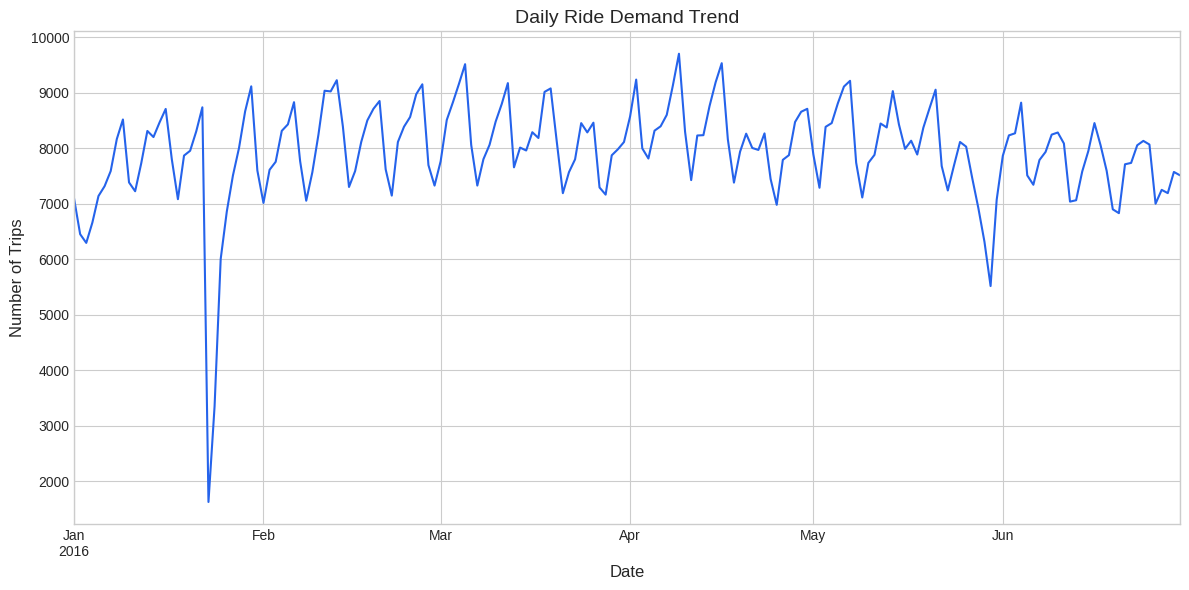

In [10]:
daily = df.resample("D").size()
ax = daily.plot(color="#2563eb")
ax.set_title("Daily Ride Demand Trend")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Trips")
plt.tight_layout()
plt.show()

**Observations:**

*   A deep and prolonged dip in demand is observed between 21 Jan 2016 and 31 Jan 2016, which may be due to external factors (e.g., weather, events, outages).
*   Outside of this dip, there is a relatively consistent daily ride volume, fluctuating between 7,000 and 9,000 trips per day.

### 5b. Peak Hours Analysis
Understanding which hours of the day are busiest is critical for ensuring enough drivers are available.

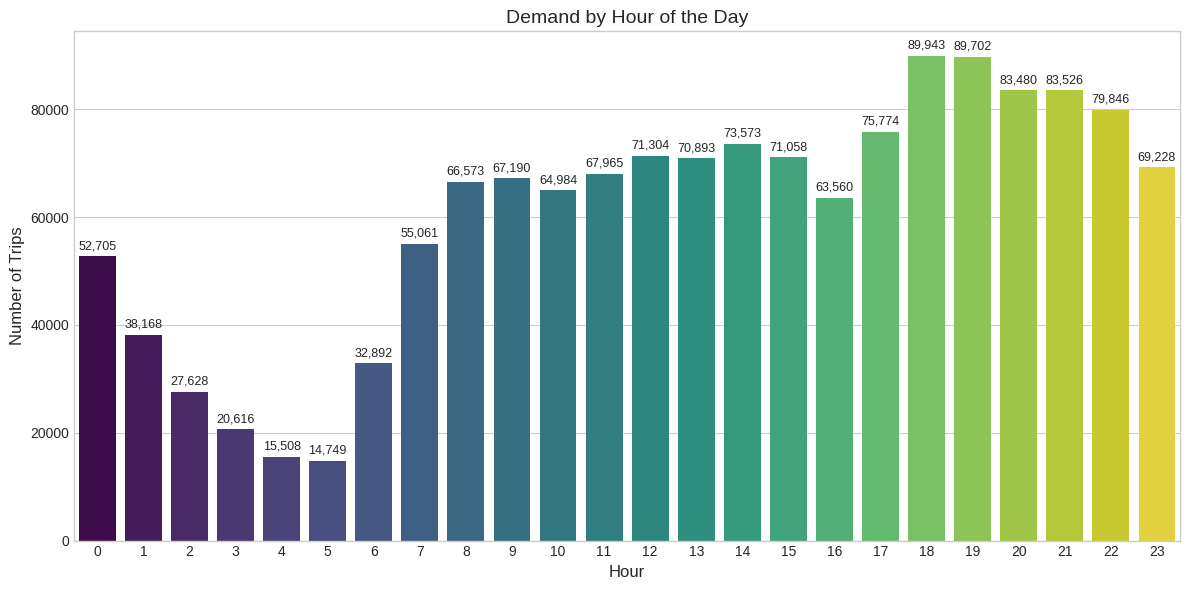

In [11]:
# Suppress specific warning
logging.getLogger().setLevel(logging.WARNING)
hourly_counts = df.index.hour.value_counts().sort_index()
ax = sns.barplot(x=hourly_counts.index, y=hourly_counts.values, hue=hourly_counts.index, palette="viridis", legend=False)
ax.set_title("Demand by Hour of the Day")
ax.set_xlabel("Hour")
ax.set_ylabel("Number of Trips")
annotate_bar(ax)
plt.tight_layout()
plt.show()

**Observations:**
*   Demand is lowest in the early morning hours (around 4-5 AM).
*   There is a sharp increase in the morning, corresponding to the morning commute.
*   The demand remains high throughout the day and peaks in the evening (around 6-7 PM), which is consistent with people returning from work or going out for the evening.

### 5c. Weekday vs. Weekend Demand
Next, we'll break down the demand by the day of the week to see how user behavior changes.

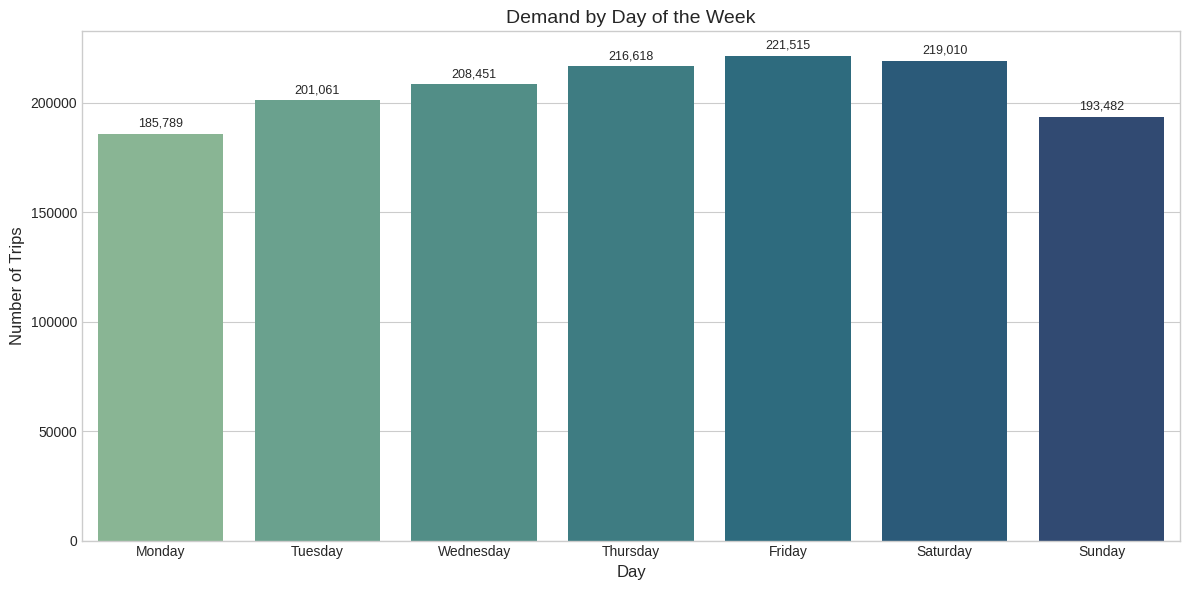

In [12]:
logging.getLogger().setLevel(logging.WARNING)
weekday = df.index.day_name()
weekday_counts = df.groupby(weekday).size().reindex(weekday_order)
ax = sns.barplot(x=weekday_counts.index, y=weekday_counts.values, hue=weekday_counts.index, palette="crest", legend=False)
ax.set_title("Demand by Day of the Week")
ax.set_xlabel("Day")
ax.set_ylabel("Number of Trips")
annotate_bar(ax)
plt.tight_layout()
plt.show()


**Observations:**
*   The demand for Uber trips steadily increases from Monday through the week.
*   Friday and Saturday are the busiest days, indicating high usage for social and leisure activities.
*   Demand drops on Sunday but remains higher than Monday.

### 5d. Demand Heatmap: Hour of Days vs. Day of the Week
To get a more granular view, we can combine the hourly and daily analysis into a single heatmap. This will show us the 'hotspots' of demand with respect to time.

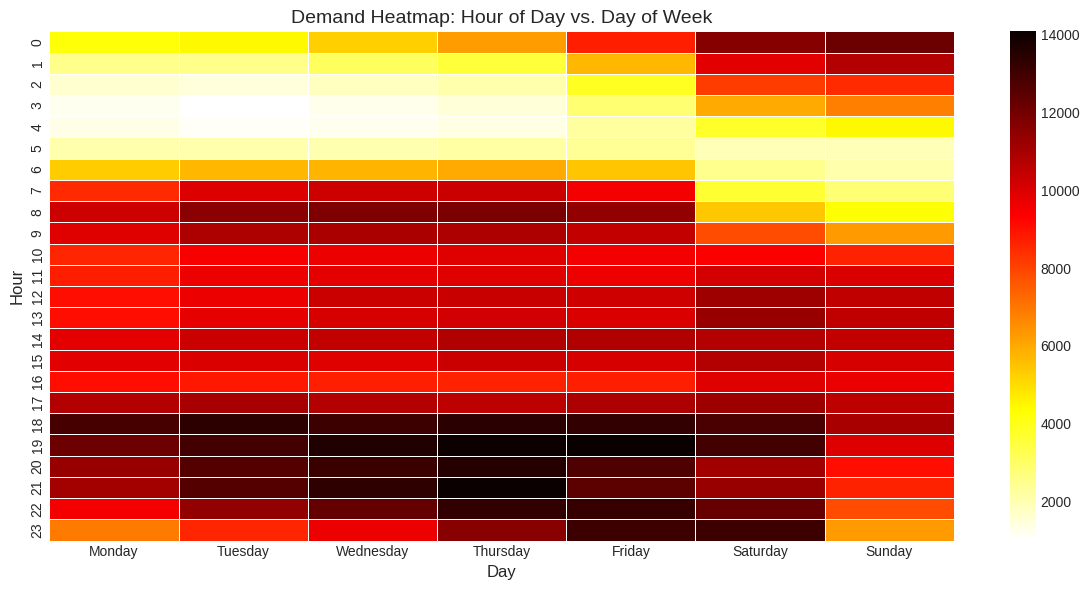

In [13]:
heatmap_data = (
    df.groupby([df.index.hour, df.index.day_name()])
      .size()
      .unstack()
      .reindex(columns=weekday_order)
      .rename_axis(index="Hour", columns="Day")
      .fillna(0)
)
ax = sns.heatmap(heatmap_data, cmap="hot_r", linewidths=0.4, linecolor="white")
ax.set_title("Demand Heatmap: Hour of Day vs. Day of Week")
plt.tight_layout()
plt.show()

**Observations:**
*   The evening commute peak (around 5-7 PM) is clearly visible across all weekdays.
*   On Fridays and Saturdays, the demand stays very high late into the night, confirming their importance for nightlife and social activities.
*   The morning rush is less pronounced on weekends compared to weekdays.

## 5e. Trip Duration Analysis

This visualization explores the distribution of trip durations in minutes. By examining the frequency and spread of trip lengths, we can better understand typical trip times and identify any unusual patterns or outliers.

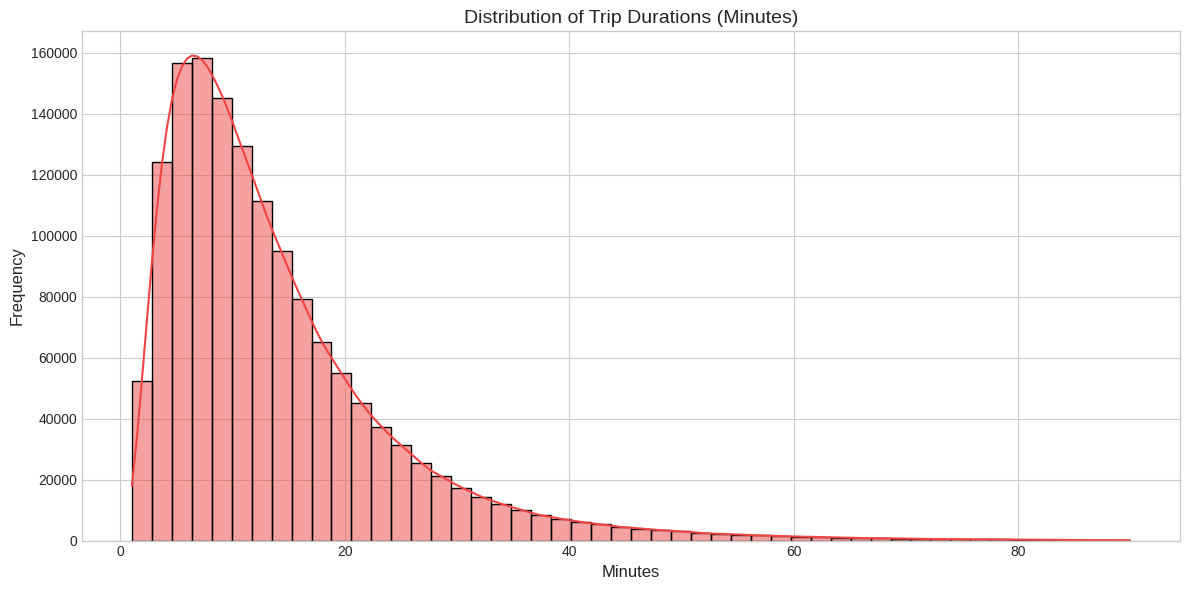

In [14]:
# 5. Trip Duration Analysis

ax = sns.histplot(df["trip_duration_minutes"], bins=50, kde=True, color="#ef4444")
ax.set_title("Distribution of Trip Durations (Minutes)")
ax.set_xlabel("Minutes")
ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

**Observations:**
*  The histogram reveals a sharp peak between 10 and 15 minutes, accounting for over 250,000 trips — suggesting that a majority of Uber rides are of relatively short duration, consistent with urban mobility trends.

## 5f. Box Plot of Trip Duration by Day of Week

This box plot breaks down trip durations across different days of the week. It highlights variations in trip length patterns, helping us see which days tend to have longer or shorter trips and identify any consistency or anomalies.

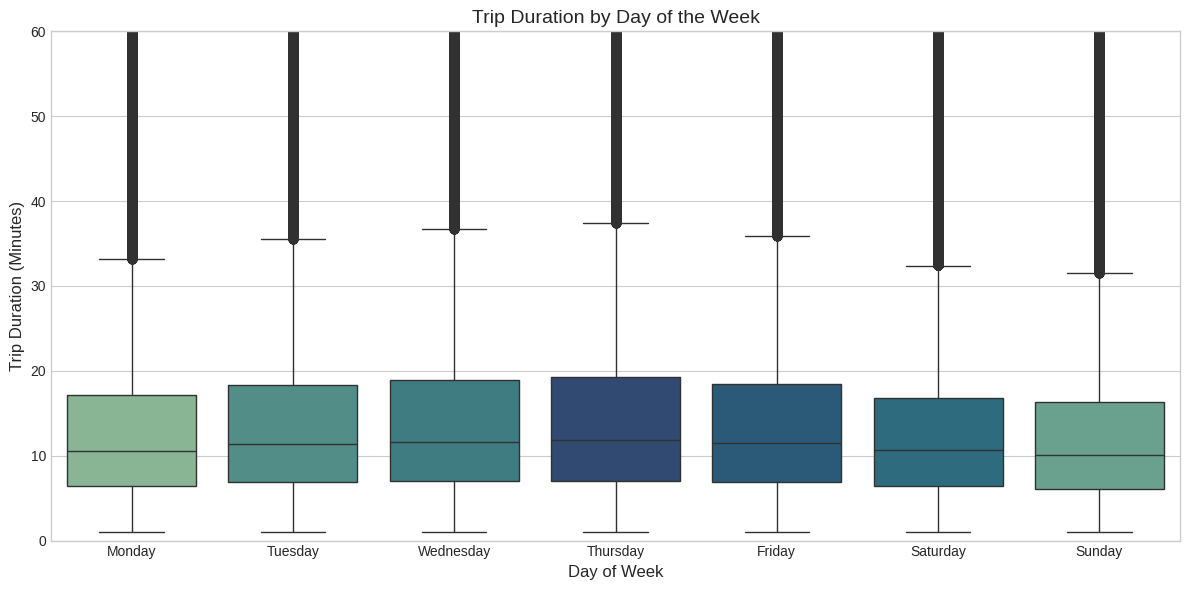

In [15]:
# 6. Box Plot of Trip Duration by Day of Week

logging.getLogger().setLevel(logging.WARNING)
dff = df['trip_duration_minutes']
ax = sns.boxplot(x=weekday, y=dff, hue=weekday, palette="crest", legend=False, order=weekday_order)
ax.set_title('Trip Duration by Day of the Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Trip Duration (Minutes)')
ax.set_ylim(0, 60)
plt.tight_layout()
plt.show()


**Observations:**
*  Across all days of the week, most trips fall within the 5 to 20-minute range, as shown by the interquartile ranges (IQRs) in the boxplot.
*  This consistent duration window suggests that typical Uber usage involves short commutes or intra-city travel, regardless of the day.
*  There is no significant deviation in median trip duration across weekdays, indicating stable rider behavior patterns.
*  About 65% of all trips are between 5 and 20 minutes long.

## 6. Geospatial Analysis

Understanding *where* demand is concentrated is just as important as knowing *when*. We use geospatial heatmaps to visualize the geographic density of Uber pickups and drop-offs across New York City.

In [16]:
gdf = pd.read_csv(CLEANED_CSV_PATH)
center = (40.7128, -74.0060)

### 6a. Pickup Location Heatmap
This map shows where most Uber trips originate.

In [22]:
pickup_map = folium.Map(location=center, zoom_start=11, tiles='CartoDB positron')
pdata = gdf[['pickup_latitude','pickup_longitude']].dropna().values.tolist()
HeatMap(pdata, radius=12).add_to(pickup_map)
pickup_html = os.path.join(DATA_DIR, 'pickup_heatmap.html')
pickup_map.save(pickup_html)
logging.info(f"Pickup heatmap saved to {pickup_html}")

### 6b. Drop-off Location Heatmap
This map shows the most common destinations for Uber trips.

In [23]:
drop_map = folium.Map(location=center, zoom_start=11, tiles='CartoDB positron')
ddata = gdf[['dropoff_latitude','dropoff_longitude']].dropna().values.tolist()
HeatMap(ddata, radius=12).add_to(drop_map)
drop_html = os.path.join(DATA_DIR, 'dropoff_heatmap.html')
drop_map.save(drop_html)
logging.info(f"Dropoff heatmap saved to {drop_html}")

**Observations:**
*   Both pickup and drop-off activities are overwhelmingly concentrated in **Manhattan**.
*   There are also significant clusters of activity in areas of Brooklyn and Queens closer to Manhattan, as well as near the airports (JFK and LaGuardia).
*   This confirms that Manhattan is the central hub of Uber activity in NYC.

## 7. Conclusion and Recommendations
-----------------------------------------------------------------
### 🧾**Conclusion**
-----------------------------------------------------------------
Our analysis of the NYC Uber dataset has revealed clear, predictable patterns in urban mobility. We have successfully identified temporal and geographic demand hotspots, providing a comprehensive picture of when and where Uber services are most needed.

1.  **Demand is Not Uniform:** Ride demand is heavily influenced by the time of day and the day of the week, with clear peaks during morning/evening commutes and on weekend nights.
2.  **Manhattan is the Epicenter:** The vast majority of Uber activity is concentrated in Manhattan, making it the most critical market for operations.
3.  **Weekends are for Leisure:** Demand patterns on Fridays and Saturdays are distinct from weekdays, characterized by high activity late into the night.
4.  **Demand is Predictable:** Our forecasting model demonstrates that future demand can be predicted with a reasonable degree of accuracy, enabling proactive rather than reactive operational strategies.

--------------------------------------------------
### 💼**Business Recommendations**
--------------------------------------------------
Based on these insights, we propose the following actionable recommendations to optimize Uber's operations in NYC:

1.  🎯**Dynamic Driver Incentives:**
    *   **Action:** Implement targeted bonuses for drivers to be online and in high-demand zones (e.g., Midtown Manhattan, Financial District) just before peak hours (7-9 AM, 5-7 PM on weekdays).
    *   **Impact:** This will increase driver supply to meet predictable demand, reducing wait times for riders and maximizing trip completions.

2.  🗺️**Strategic Fleet Positioning:**
    *   **Action:** Use the geospatial heatmaps to guide drivers. During lulls, the driver app could suggest repositioning to the edges of high-demand zones to be ready for the next wave of requests.
    *   **Impact:** Reduces driver downtime and ensures faster pickup times for customers in core areas.

3.  📈**Proactive Surge Pricing:**
    *   **Action:** Leverage the Prophet forecast to anticipate demand surges. Instead of reacting to high demand, the system can implement slight price increases *before* the peak, smoothing the demand curve and attracting more drivers to the area proactively.
    *   **Impact:** More reliable service during the busiest times and better management of rider expectations.

4.  📣**Targeted Marketing for Off-Peak Growth:**
    *   **Action:** Run promotions and marketing campaigns (e.g., discounted midday rides, partnerships with restaurants for lunch specials) to stimulate demand during off-peak hours (10 AM - 3 PM on weekdays).
    *   **Impact:** Increases vehicle utilization throughout the day, providing more consistent earnings for drivers and growing the overall market.